
Created: 26.06.2025

Author: Pippa Edwards

Sources used: https://seaborn.pydata.org/, https://coolors.co/, https://www.geeksforgeeks.org/ ChatGPT for violin plots and map of poc points (specifically the colourbar and scaling)

This code looks at:
- the distribution of the input data into stan
- the output of the stan model posteriors
- the datasets generated by the stan model


In [3]:
#import packages
import pandas as pd
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
import os
import matplotlib.colors as mcolors
os.chdir("C:/Users/pe1n24/Desktop/STAN/")


In [8]:
#load in dataset
poc = pd.read_csv("C:/Users/pe1n24/Desktop/poc_data_070525/flux_data_andvars_0107.csv")
poc = poc[poc["log_POC"]>= -2.5]
poc = poc[poc["Depth"] >= 100]
poc = poc.dropna()
xvars = ["Intercept", "SST", "logChla", "logDepth"]


In [78]:
#set up seaborn

#sns.set_theme(context = "paper", style = "ticks", font = "arial")
sns.set_theme(context = "talk", style = "ticks", font = "arial")

(12183, 17)


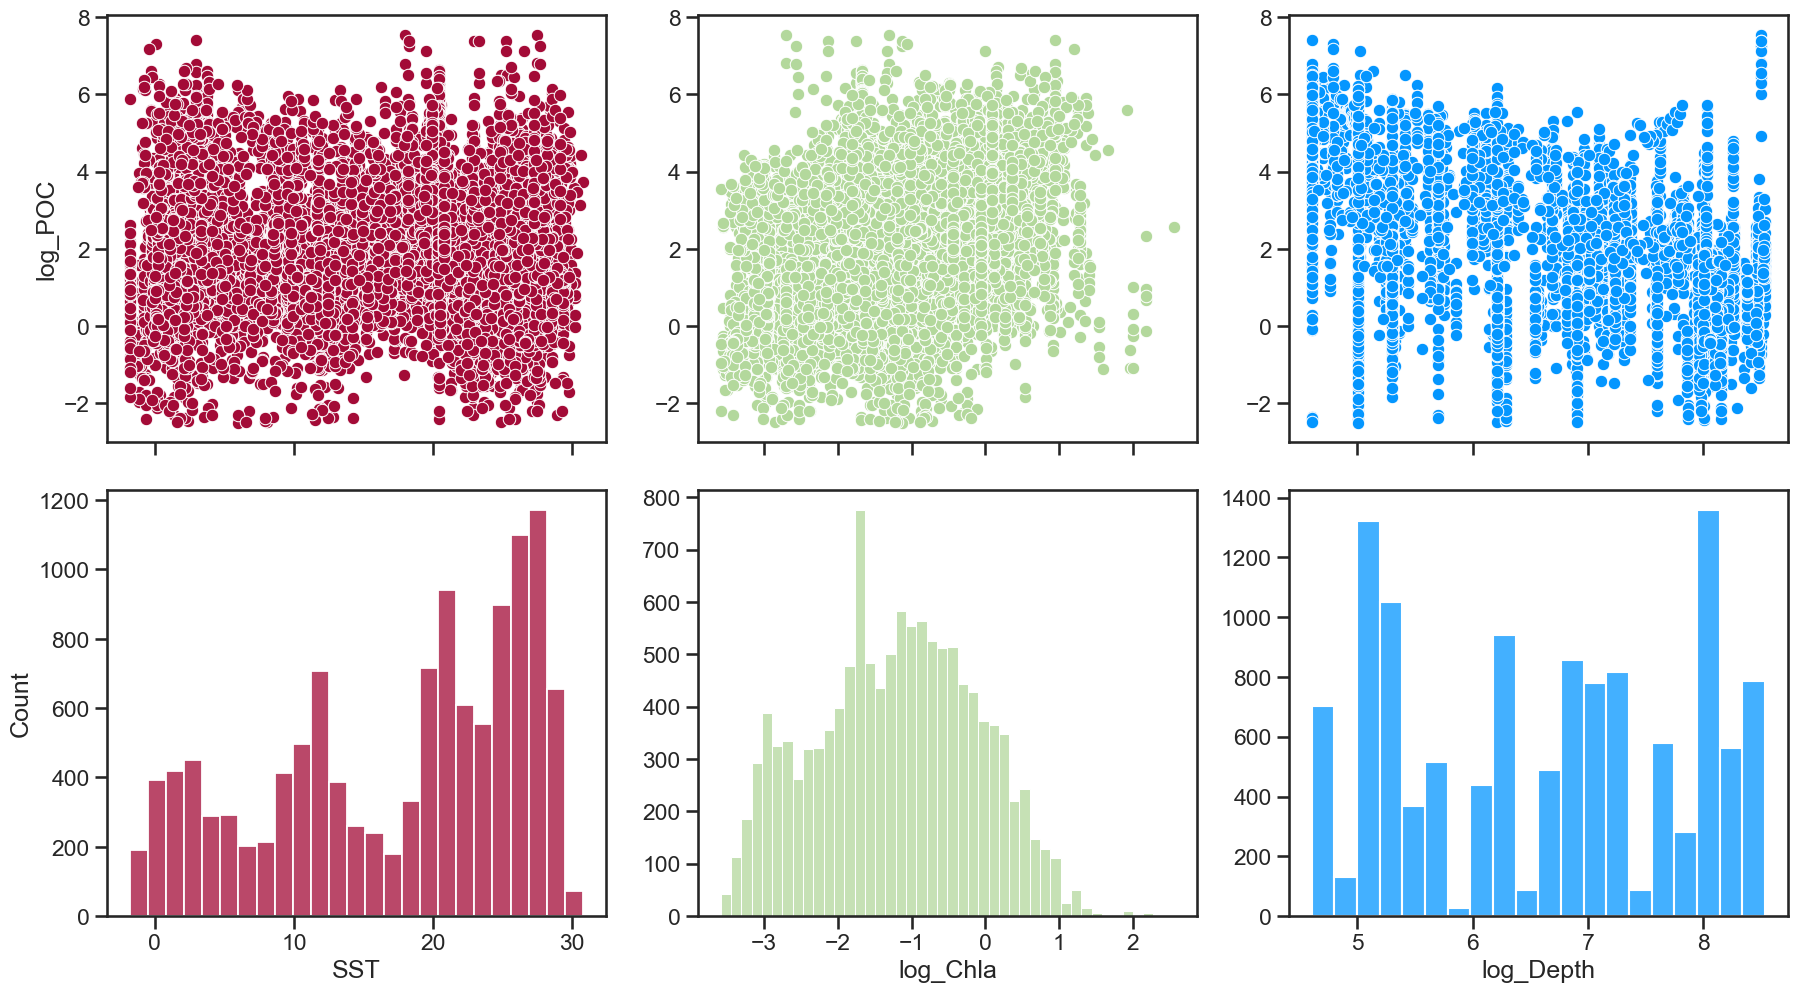

In [ ]:

#plot the POC input data
var_palette = ["#6b6b6b","#a30b37", "#b3d89c", "#0496ff"]
fig, ax = plt.subplots(2,3, figsize = (18,10), sharex = "col")
plt.tight_layout()
sns.scatterplot(data = poc, x = "SST", y = "log_POC", color = "#a30b37", ax = ax[0,0])
sns.scatterplot(data = poc, x = "log_Chla", y = "log_POC", color = "#b3d89c", ax = ax[0,1])
sns.scatterplot(data = poc, x = "log_Depth", y = "log_POC", color = "#0496ff", ax = ax[0,2])

sns.histplot(data = poc, x = "SST",color = "#a30b37", ax = ax[1,0])
sns.histplot(data = poc, x = "log_Chla", color = "#b3d89c", ax = ax[1,1])
sns.histplot(data = poc, x = "log_Depth", color = "#0496ff", ax = ax[1,2])

for n in range(2):
    ax[n,1].set_ylabel(" ")
    ax[n,2].set_ylabel(" ")
print(poc.shape)

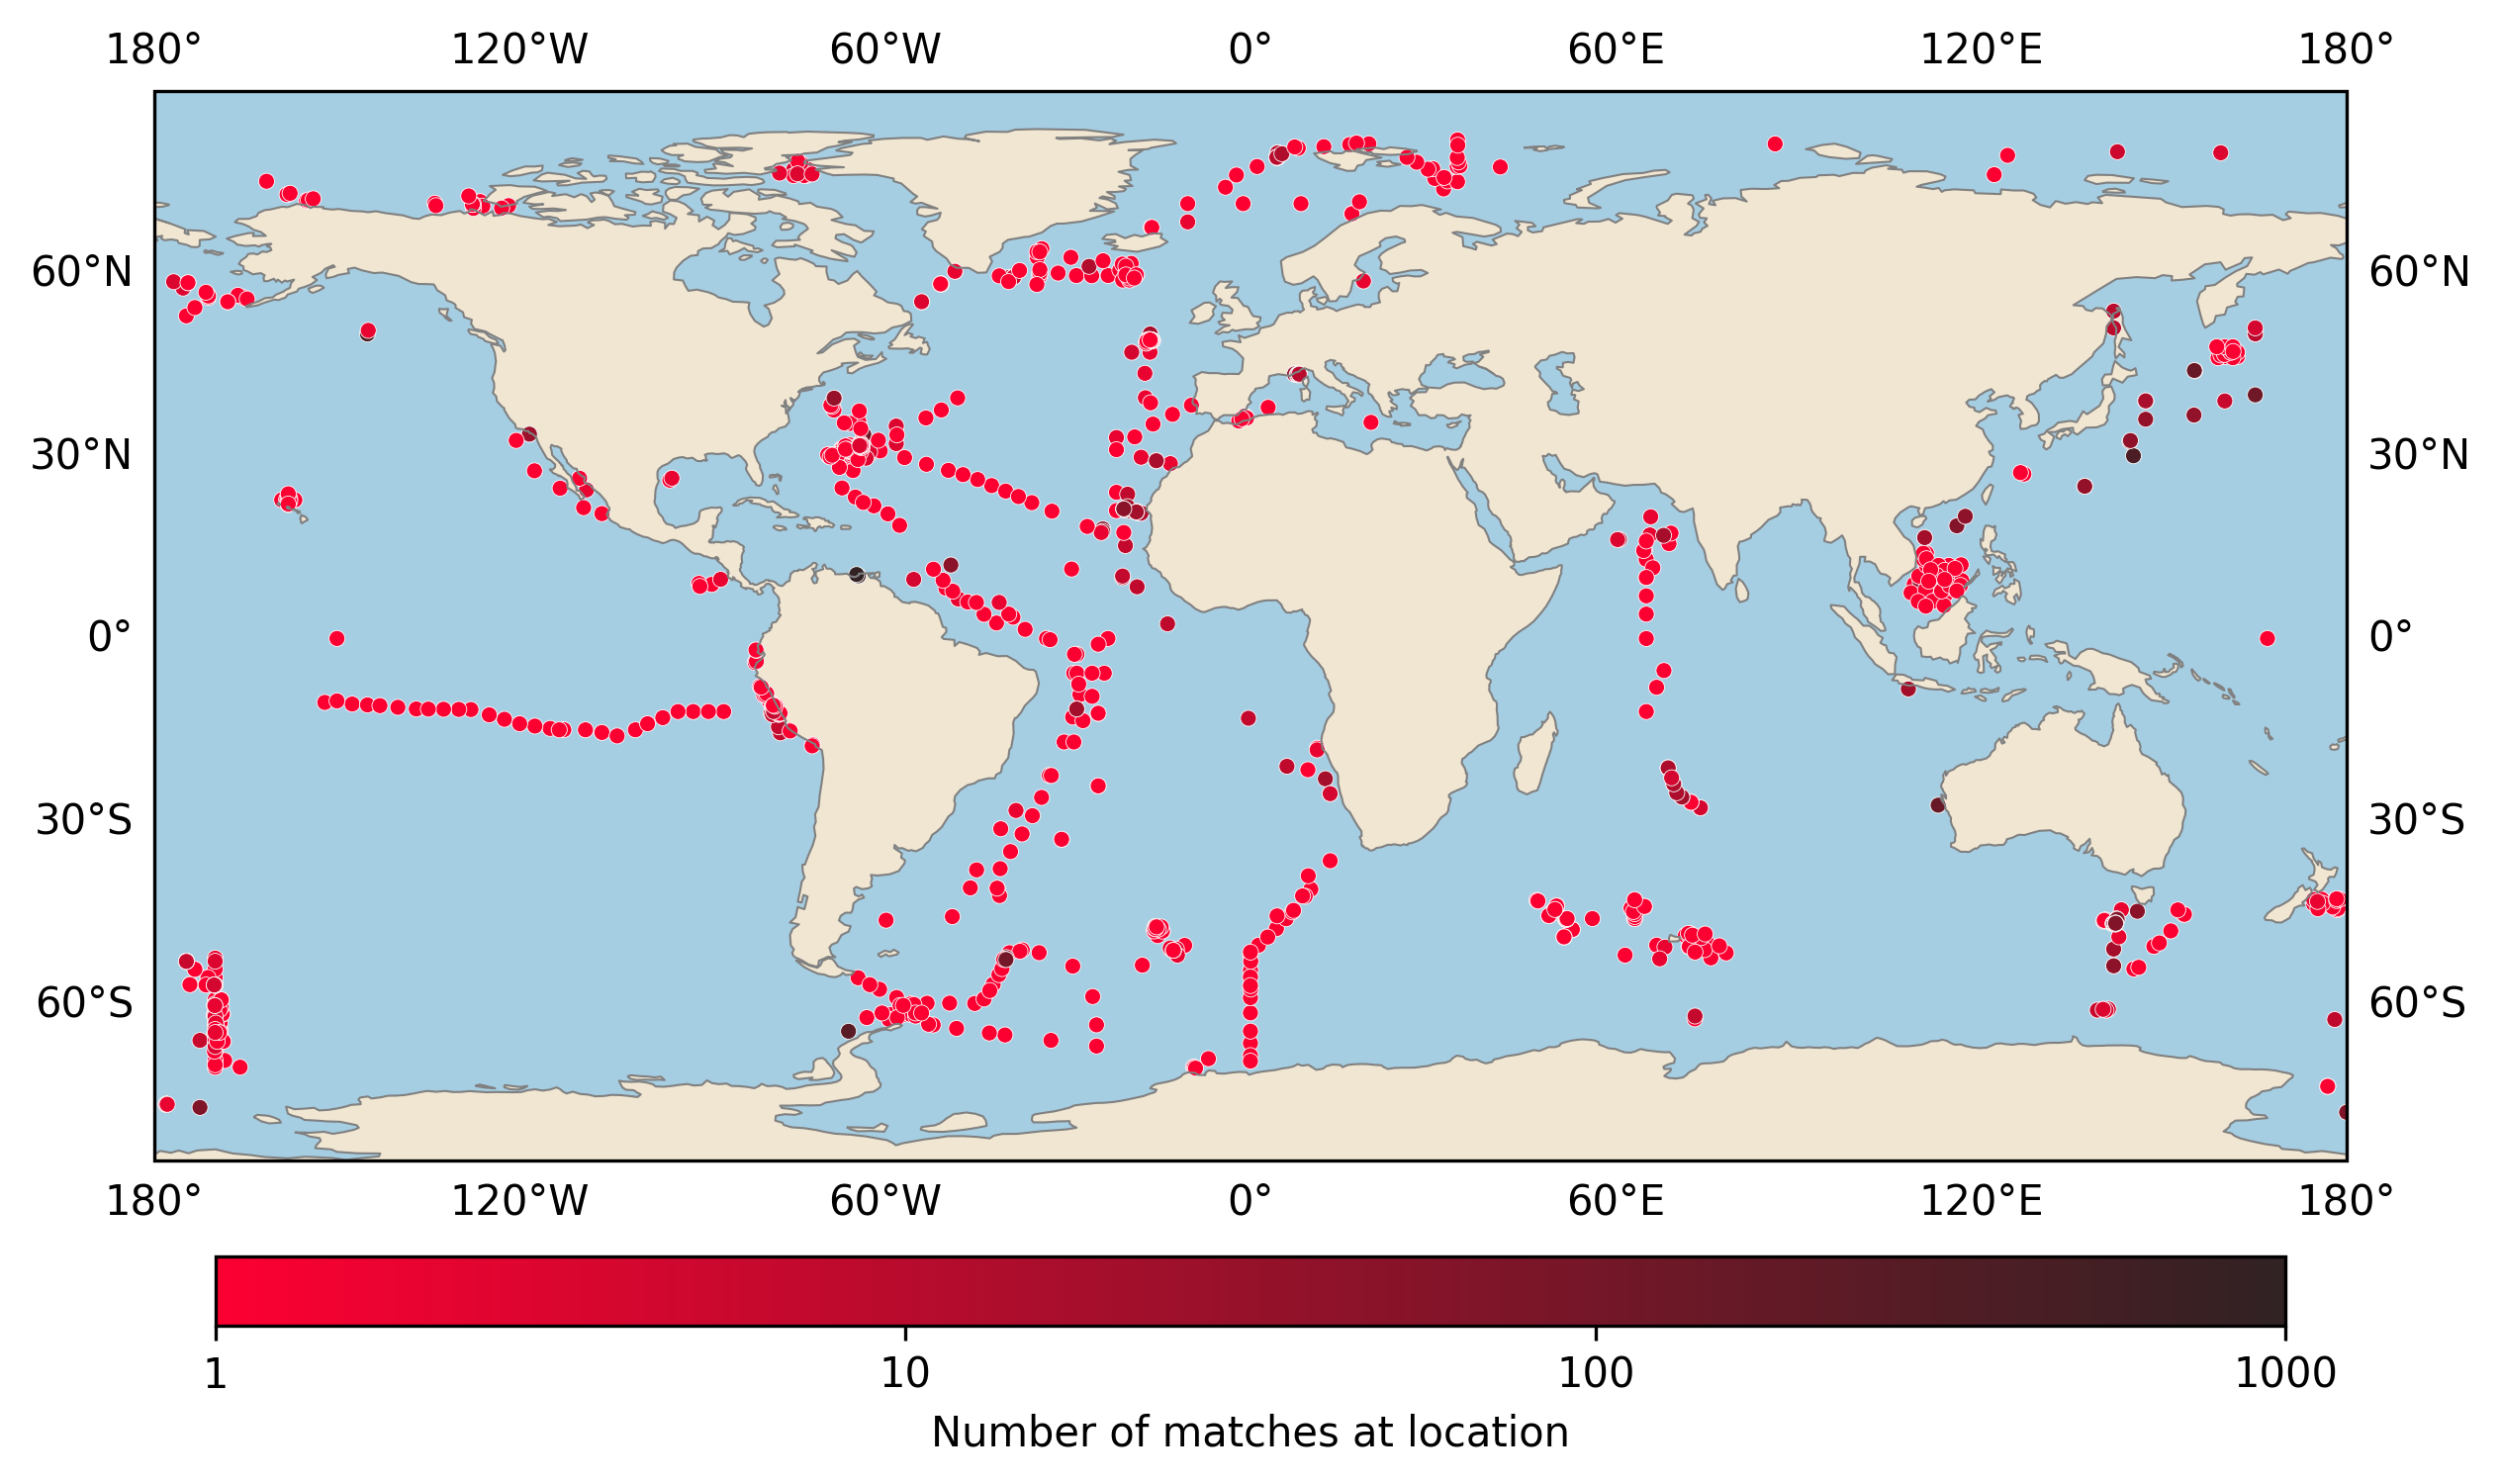

In [ ]:
#map of poc data:

#set up dataset that counts the number of matches at each lat and lon
pocdf = pd.DataFrame({"Lat":[],
                      "Lon":[],
                      "No. Matches":[],
                      "Mean POC":[],
                      "Median POC":[],
                      "Min POC":[],
                      "Max POC":[]})

lats = list(set(poc["Latitude"]))
lons = list(set(poc["Longitude"]))
for lat in lats:
    ldf = poc[poc["Latitude"] == lat]
    for lon in lons:
        lldf = ldf[ldf["Longitude"] == lon]
        if lldf.shape[0] > 0:
            pocdf.loc[len(pocdf)] = [lat, lon, lldf.shape[0],
                                     np.mean(lldf["POC"]), np.median(lldf["POC"]),
                                    np.min(lldf["POC"]), np.max(lldf["POC"])]


#set up scaled dataset
scaled = np.log10(pocdf["No. Matches"])
scaled_norm = (scaled - scaled.min()) / (scaled.max() - scaled.min())
cmap = sns.dark_palette("#FC0032", reverse = True, as_cmap = True)
colors_rgba = cmap(scaled_norm)
pocdf['color'] = [mcolors.to_hex(rgba) for rgba in colors_rgba]

#set up colourbar
norm = mcolors.Normalize(vmin=scaled.min(), vmax=round(scaled.max()))
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
log_ticks = np.arange(0, round(scaled.max())+1, 1)
orig_ticks = [ '%.0f' % elem for elem in 10**(log_ticks)]

#set up figure
fig = plt.figure(figsize=(10, 6), dpi = 300)
ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(cfeature.OCEAN, facecolor='#a6cee3')  # light blue ocean
ax.add_feature(cfeature.LAND, facecolor='#f0e6d2')   # beige/light tan land
ax.coastlines(resolution='110m', linewidth=0.5, color='gray')
ax.gridlines(draw_labels = True, linestyle = "--", color = "#B3B3B3", alpha  = 0.5)

#add points
ax.scatter(pocdf["Lon"], pocdf["Lat"],transform=ccrs.PlateCarree(),
            s=15, color=pocdf["color"], edgecolor='w', linewidth = 0.2)

#add colour bar
cbar = plt.colorbar(sm, ax=ax, orientation='horizontal', pad=0.07 , aspect = 30, shrink = 0.9, ticks = log_ticks)
cbar.ax.set_xticklabels(orig_ticks) 
cbar.set_label("Number of matches at location")

plt.show()

In [ ]:
#Read in stan data
df = pd.read_csv("output/final_data_stanrun.csv")
sumstats = pd.read_csv("output/final_data_sumstats.csv")

Index(['chain__', 'iter__', 'draw__', 'lp__', 'accept_stat__', 'stepsize__',
       'treedepth__', 'n_leapfrog__', 'divergent__', 'energy__',
       ...
       'y_sim[12174]', 'y_sim[12175]', 'y_sim[12176]', 'y_sim[12177]',
       'y_sim[12178]', 'y_sim[12179]', 'y_sim[12180]', 'y_sim[12181]',
       'y_sim[12182]', 'y_sim[12183]'],
      dtype='object', length=36567)

In [94]:
#EXTRACT BETA AND GAMMA DATA
betas = df.filter(like = "beta")
gammas = df.filter(like = "gamma")

#join together
posts = pd.concat([betas, gammas], axis=1)
cols = list(posts.columns.values)

Plots of stan output

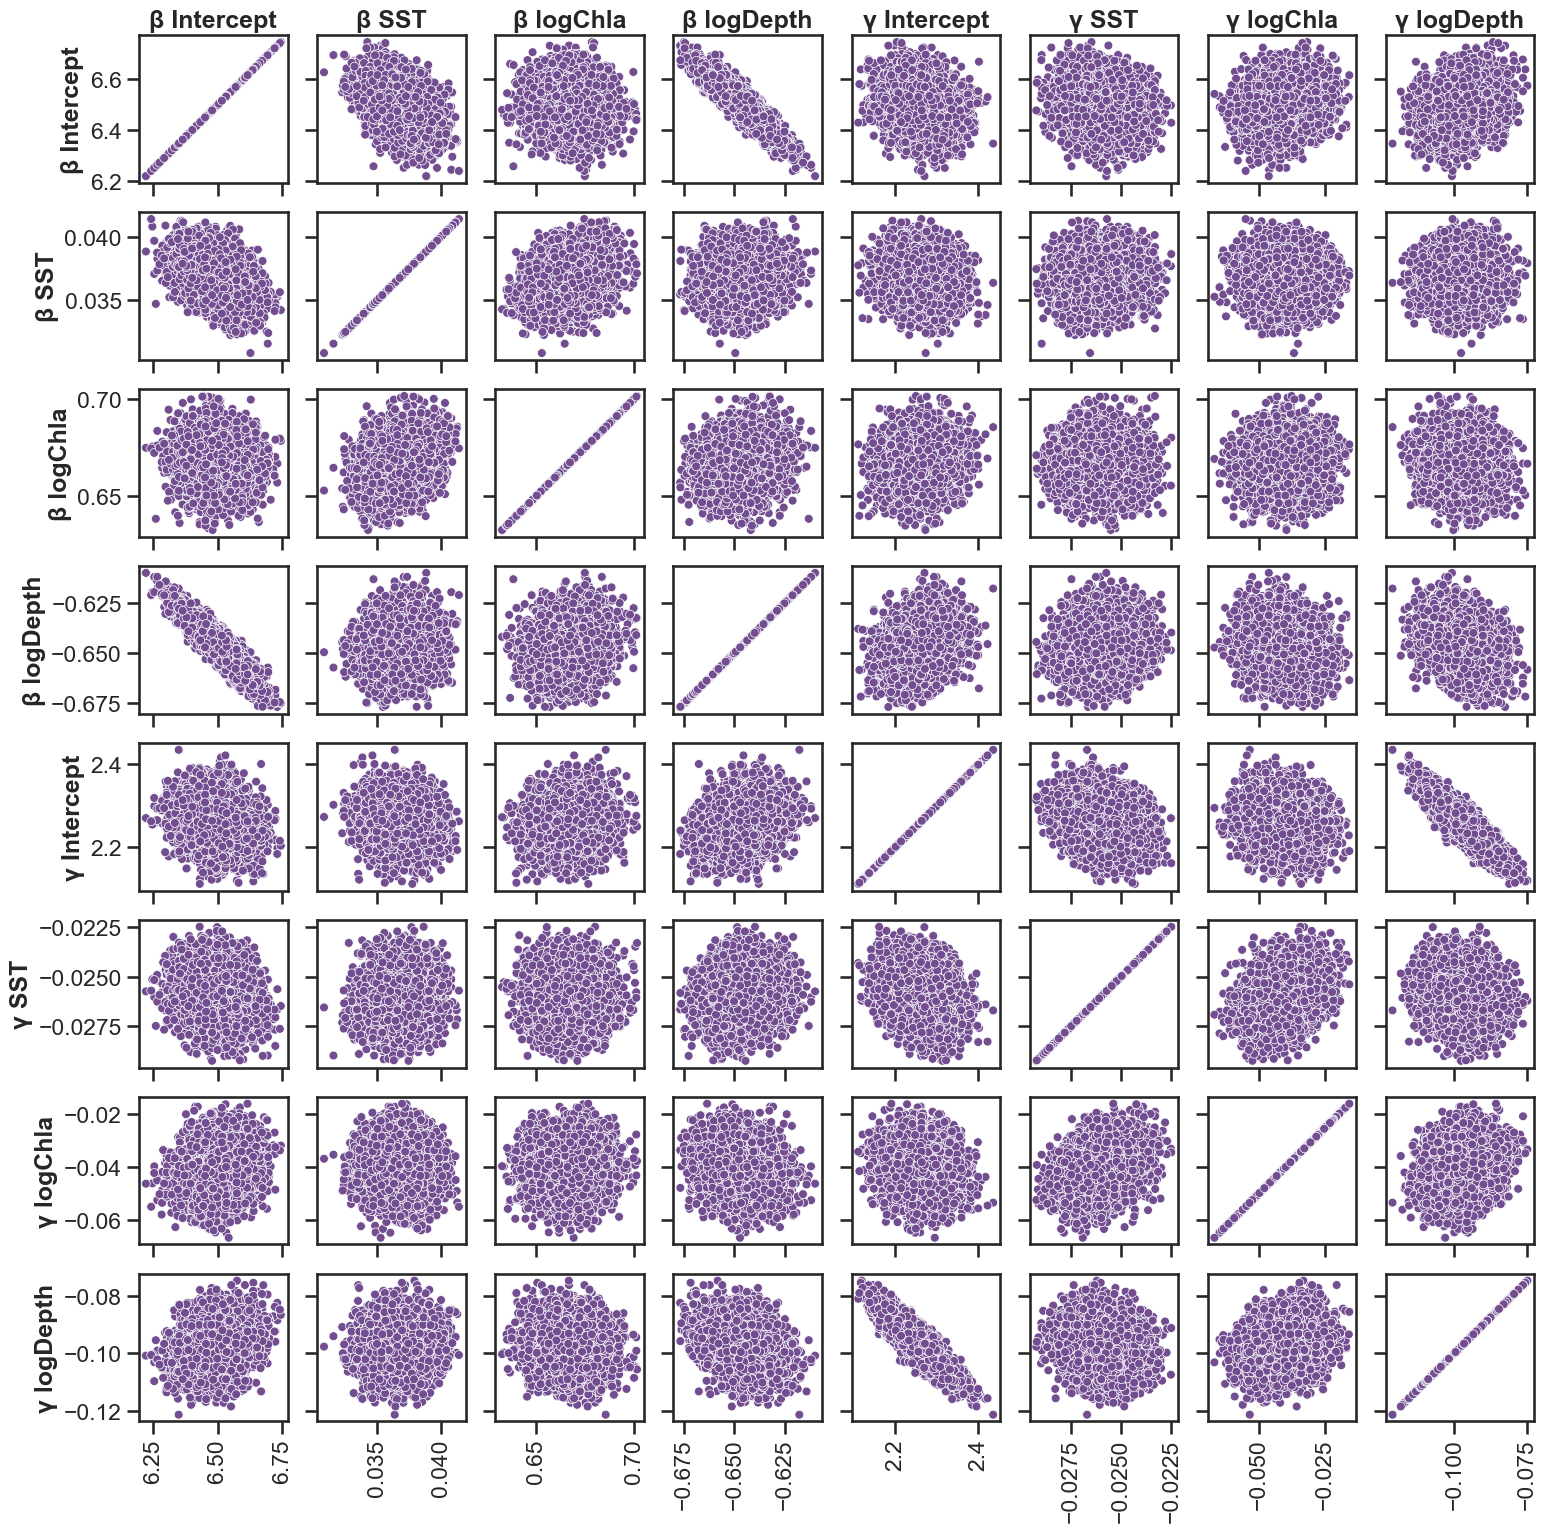

In [93]:
#Posterior vs posterior

fig, ax = plt.subplots(posts.shape[1], posts.shape[1], figsize = (18,18), sharex='col', sharey='row')
for a in range(posts.shape[1]):
    acol = cols[a]
    for b in range(posts.shape[1]):
        bcol= cols[b]
        ano = acol[-2]
        bno = bcol[-2]
        ydata = posts[f"{acol}"]
        xdata = posts[f"{bcol}"]
        sns.scatterplot(x = xdata, y = ydata, ax = ax[a,b], size = 8, color = "#724E91", legend = False)
        ax[a,b].set(xlabel = "", ylabel = "")
for a in range(posts.shape[1]):

    ax[posts.shape[1]-1,a].tick_params("x",rotation = 90)
    
    acol = cols[a]
    if a < betas.shape[1]:
        ax[a,0].set_ylabel(f"β {xvars[int(acol[-2])-1]}", weight = "bold")
        ax[0,a].set_title(f"β {xvars[int(acol[-2])-1]}", weight = "bold")       
    else:
        ax[a,0].set_ylabel(f"γ {xvars[int(acol[-2])-1]}", weight = "bold")
        ax[0,a].set_title(f"γ {xvars[int(acol[-2])-1]}", weight = "bold")
plt.show()

In [95]:
#Caterpillar plot of beta and gamma values

#get data in right format
mposts = posts.melt()
mbetas = betas.melt()
mbetas1 = mbetas[mbetas["variable"]!= "beta[1]"]
mgammas = gammas.melt()
mgammas1 = mgammas[mgammas["variable"]!= "gamma[1]"]

# sns.catplot(
#     data= mgammas1, x="value", y="variable",
#     kind="violin", inner = None, split = True, hue = "variable")
# plt.axline((0,0), (0,1), c = "black", ls = "--")
# plt.title("Gammas")
# plt.yticks(ticks = np.arange(0,3,1), labels = xvars[1:])
# plt.show()

# sns.catplot(
#     data= mbetas1, x="value", y="variable",
#     kind="violin", inner = None, split = True)
# plt.axline((0,0), (0,1), c = "black", ls = "--")
# plt.yticks(ticks = np.arange(0,3,1), labels = xvars[1:])
# plt.title("Betas")
# plt.show()

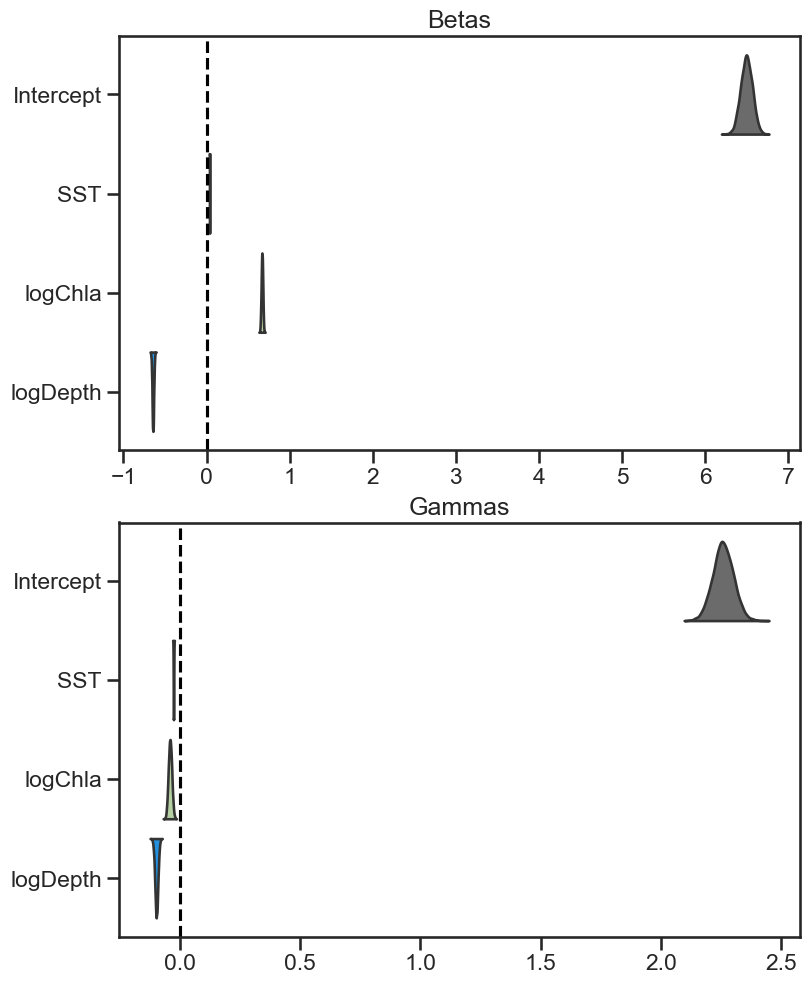

In [ ]:
#violins with intercepts

fig, ax = plt.subplots(2,1, figsize = (8,10))
fig.tight_layout()

sns.violinplot(data = mbetas, x = 'value', y = "variable", hue = "variable", density_norm='count',
               inner = None, split = True, palette = var_palette, ax = ax[0])
ax[0].axline((0,0), (0,1), c = "#b4b4b4", ls = "--")
ax[0].set_title("Betas")
ax[0].set_yticks(ticks = np.arange(0,4,1), labels = xvars)

sns.violinplot(data = mgammas, x = 'value', y = "variable", hue = "variable", density_norm='count',
               inner = None, split = True, palette = var_palette, ax = ax[1])
ax[1].axline((0,0), (0,1), c = "#b4b4b4", ls = "--")
ax[1].set_title("Gammas")
ax[1].set_yticks(ticks = np.arange(0,4,1), labels = xvars)

ax[1].set_ylabel("")
ax[0].set_ylabel("")
ax[1].set_xlabel("")
ax[0].set_xlabel("")
plt.show()

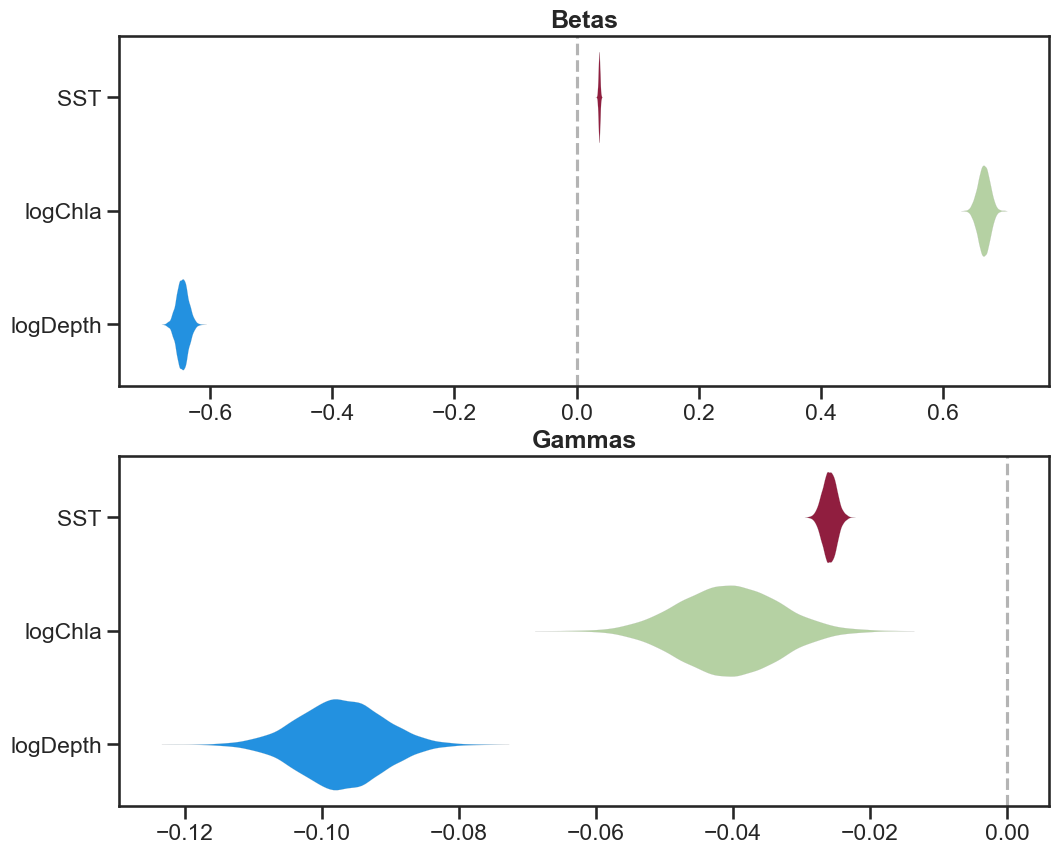

In [ ]:
#violin without intercept
fig, ax = plt.subplots(2,1, figsize = (12,10))
#fig.tight_layout()

sns.violinplot(data = mbetas1, x = 'value', y = "variable", hue = "variable", density_norm='count', 
               inner = None, palette = var_palette[1:], ax = ax[0], linewidth = 0.1, linecolor= "#b4b4b4")
ax[0].axline((0,0), (0,1), c = "#b4b4b4", ls = "--")
ax[0].set_title("Betas", weight = "bold")
ax[0].set_yticks(ticks = np.arange(0,3,1), labels = xvars[1:])

sns.violinplot(data = mgammas1, x = 'value', y = "variable", hue = "variable", density_norm='count',
               inner = None, palette = var_palette[1:], ax = ax[1], linewidth = 0.1, linecolor= "#b4b4b4")
ax[1].axline((0,0), (0,1), c = "#b4b4b4", ls = "--")
ax[1].set_title("Gammas", weight = "bold")
ax[1].set_yticks(ticks = np.arange(0,3,1), labels = xvars[1:])

for _ in range(2):
    ax[_].set_ylabel("")
    ax[_].set_xlabel("")


plt.show()

Plot the POC output of the model

In [ ]:
#extract generated mu and sigma
mus = df.filter(like = "mu")
sigmas = df.filter(like = "sigma")
print(mus.shape, sigmas.shape)


#take means and get in format to take a normal distribution
mmus = mus.mean(axis = 0).to_list()
expsigmas = np.exp(sigmas)
msigmas = expsigmas.mean(axis = 0).to_list()


#generate a daaset which takes a radnom point from a normal distrbution for each mu and sigma
#repeat but sigma = 0
ygen = []
ygen0 = []
for x in range(len(mmus)):
     y = np.random.normal(mmus[x], msigmas[x])
     ygen.append(y)
     y0 = np.random.normal(mmus[x], 0)
     ygen0.append(y0)

#calculate residuals
res = ygen - poc["log_POC"] 
res0 =ygen0- poc["log_POC"] 


(8000, 12183) (8000, 12183)


<Axes: xlabel='log_POC', ylabel='Realised logPOC with sigma = 0 residual'>

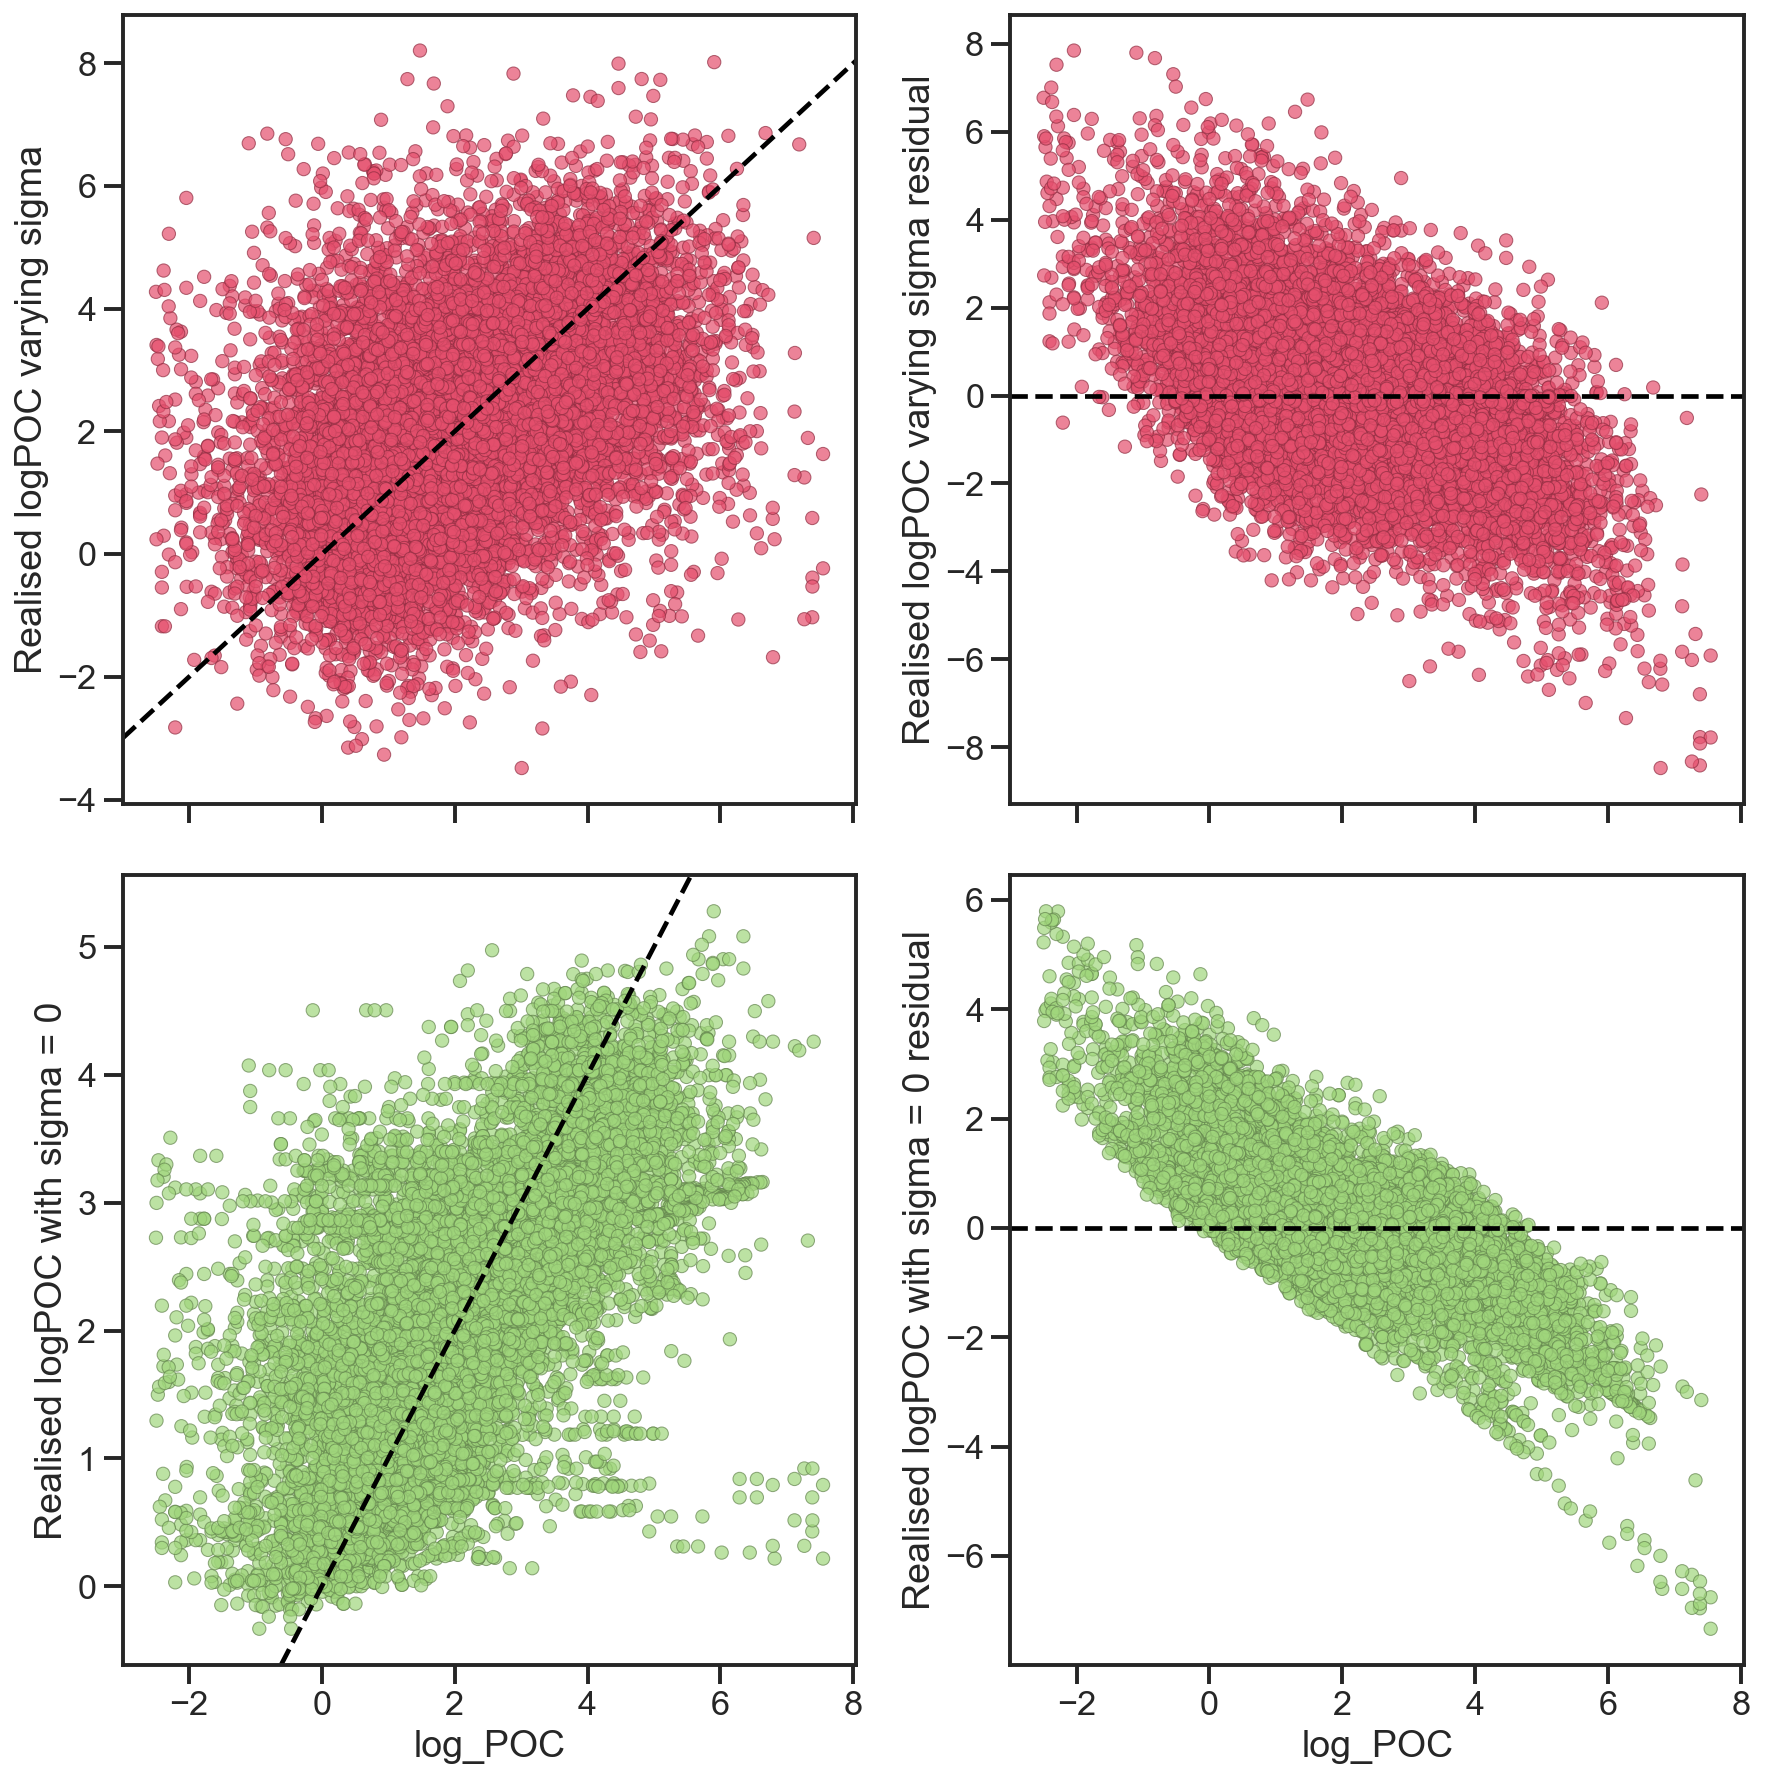

In [ ]:
#scatterplot of residualasand generated data

#set up colour palette
cs = ["#E54F6D", "#a0d67c"]
#set up labels
labels = ["Realised logPOC varying sigma",
          "Realised logPOC with sigma = 0"]

#plot generated and resiuals against original data
fig, ax=  plt.subplots(2,2, figsize = (12, 12), dpi = 150, sharex = True)
fig.tight_layout(w_pad= 1.5)
sns.scatterplot(x = poc["log_POC"], y = ygen, color = cs[0], ax = ax[0,0], alpha = 0.7, edgecolor ="#912E42", size = 2, legend = False)
sns.scatterplot(x = poc["log_POC"], y = ygen0, color = cs[1], ax = ax[1,0], alpha = 0.7, edgecolor = "#65864f", size = 2, legend = False)

for n in range(2):
    ax[n,0].axline((0,0), (1,1), color = "black", ls = "--")
    ax[n,1].axline((0,0), (1,0), color = "black", ls = "--")
    ax[n,0].set_ylabel(f"{labels[n]}")
    ax[n,1].set_ylabel(f"{labels[n]} residual")

sns.scatterplot(x = poc["log_POC"], y = res, color = cs[0], ax = ax[0,1], alpha = 0.7, edgecolor ="#912E42", size = 2, legend = False)
sns.scatterplot(x = poc["log_POC"], y = res0, color = cs[1], ax = ax[1,1], alpha = 0.7, edgecolor = "#65864f", size = 2, legend = False)



In [52]:
print(stats.pearsonr(poc['log_POC'], y = ygen))
print(stats.pearsonr(poc['log_POC'], y = ygen0))

datas = [poc['log_POC'], ygen, ygen0]
for d in datas:
    print("Mean:", round(np.mean(d), 3),
      "Std:", round(np.std(d), 3),
      "Median:", round(np.median(d), 3),
      "Min:", round(np.min(d), 3),
      "Max:", round(np.max(d), 3),
      "Range:", round(np.max(d) - np.min(d), 3))



PearsonRResult(statistic=0.4227798109329311, pvalue=0.0)
PearsonRResult(statistic=0.6507775035191199, pvalue=0.0)
Mean: 2.052 Std: 1.658 Median: 1.888 Min: -2.497 Max: 7.545 Range: 10.042
Mean: 2.066 Std: 1.665 Median: 2.021 Min: -3.485 Max: 8.207 Range: 11.692
Mean: 2.055 Std: 1.1 Median: 2.055 Min: -0.332 Max: 5.278 Range: 5.609


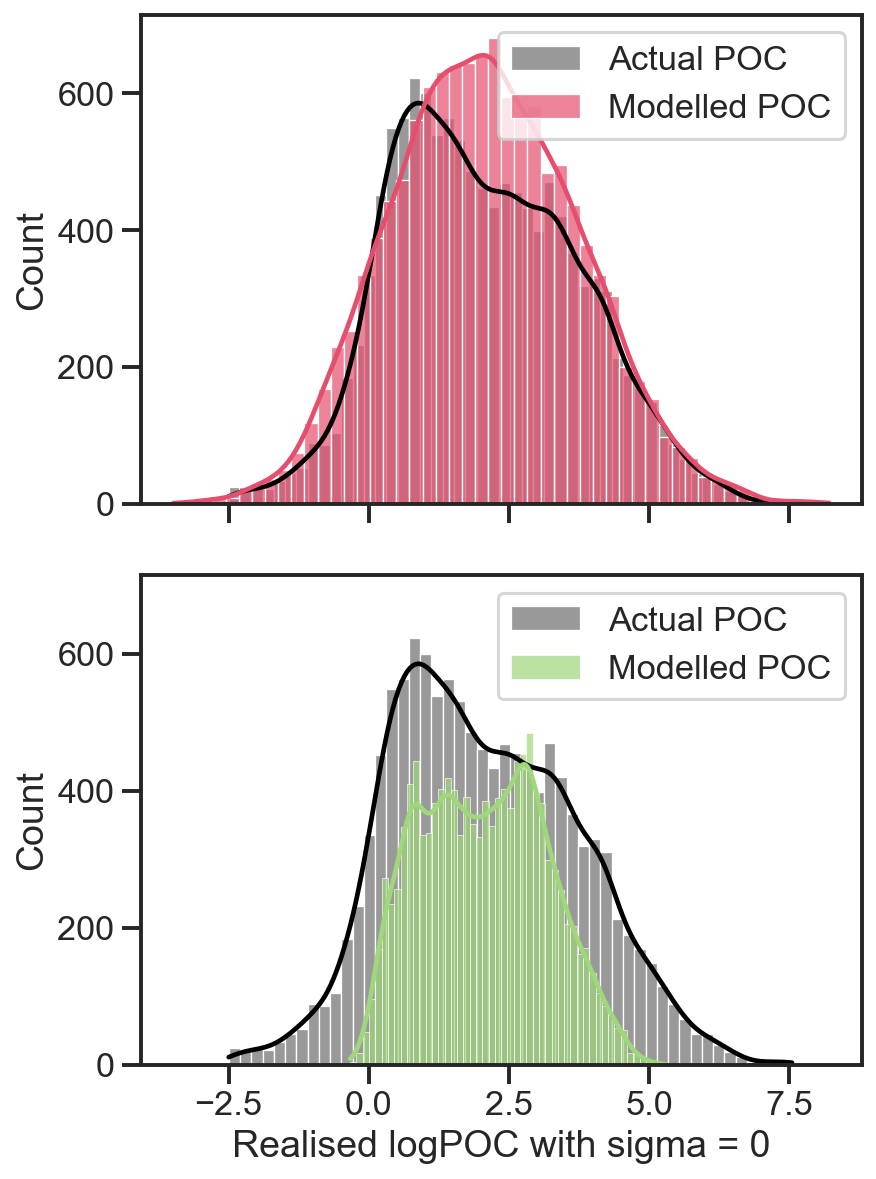

In [ ]:
#histograms of distribution of modelled vs actual POC
fig, ax=  plt.subplots(2,1, figsize = (6, 8), dpi = 150, sharey = True, sharex = True)
fig.tight_layout()

for i in range(2):
    sns.histplot(x = poc["log_POC"], ax = ax[i], alpha = 0.4, color = "black", label = "Actual POC", bins = 50, kde = True)
    ax[i].set_xlabel(f"{labels[i]}")
sns.histplot(x = ygen, ax = ax[0], alpha = 0.7, color = cs[0], label = "Modelled POC",bins= 50, kde = True)
sns.histplot(x = ygen0, ax = ax[1], alpha = 0.7, color = cs[1], label = "Modelled POC", bins = 50, kde = True)
ax[0].legend()
ax[1].legend()

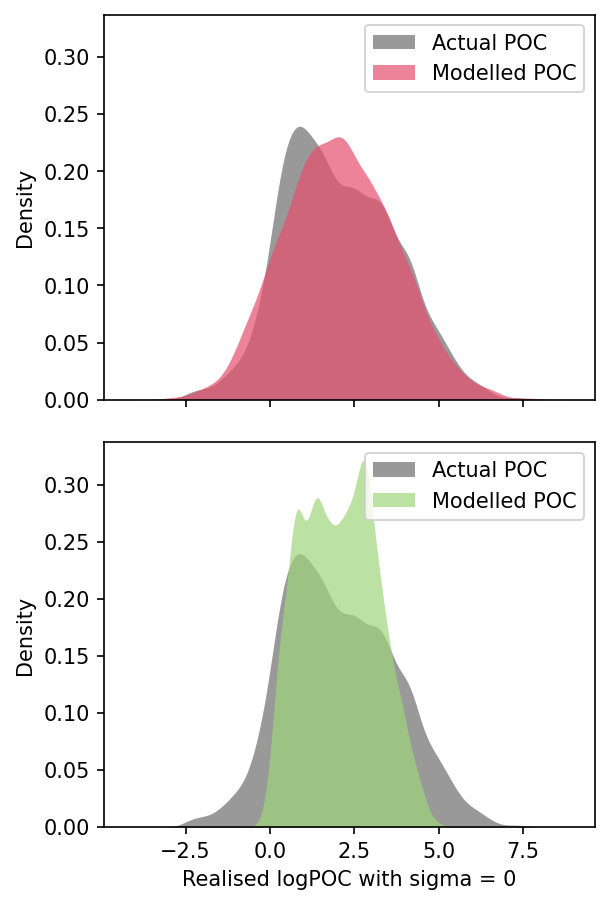

In [ ]:

#kdes of distribution of modelled vs actual POC
#change to cumulative by removing hash and bracket

fig, ax=  plt.subplots(2,1, figsize = (4, 6), dpi = 150, sharey = True, sharex = True)
fig.tight_layout()

for i in range(2):
    sns.kdeplot(x = poc["log_POC"], ax = ax[i], alpha = 0.4, color = "black", label = "Actual POC", fill = True,linewidth=0)#, cumulative = True)
    ax[i].set_xlabel(f"{labels[i]}")
sns.kdeplot(x = ygen, ax = ax[0], alpha = 0.7, color = cs[0], label = "Modelled POC",fill = True,linewidth=0)#, cumulative = True)
sns.kdeplot(x = ygen0, ax = ax[1], alpha = 0.7, color = cs[1], label = "Modelled POC",fill = True,linewidth=0)#, cumulative = True)
ax[0].legend()
ax[1].legend()

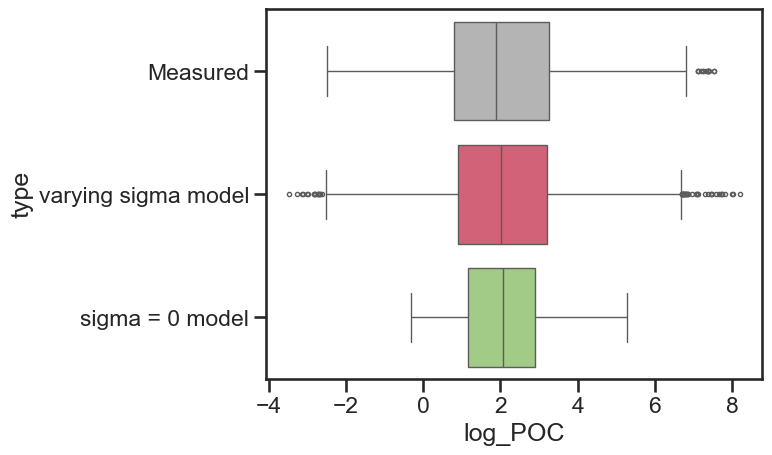

In [ ]:
#boxplots of distributions of modelled and actual POC

ys = pd.DataFrame({'log_POC': poc["log_POC"],
                   "type" : ["Measured"]*poc.shape[0] })
ys = pd.concat([ys, pd.DataFrame({'log_POC': ygen,
                   "type" : ["varying sigma model"]*poc.shape[0] })])
ys = pd.concat([ys, pd.DataFrame({'log_POC': ygen0,
                   "type" : ["sigma = 0 model"]*poc.shape[0] })])

cs1 = ["#b4b4b4", "#E54F6D", "#a0d67c"]
sns.boxplot(data = ys, x = "log_POC", y = "type", hue = "type", palette = cs1,
             fliersize = 3)
plt.show()